In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np

C:\Users\dell\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\dell\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
num_epochs = 6
num_classes = 6
batch_size = 20
learning_rate = 0.001

In [3]:
TRAIN_PATH = r"C:\Users\dell\Desktop\Data Science Bootcamp 13 homework@dsa.az\Week 11\Python-2\day1\Data\seg_train"
TEST_PATH = r"C:\Users\dell\Desktop\Data Science Bootcamp 13 homework@dsa.az\Week 11\Python-2\day1\Data\seg_test"
MODEL_STORE_PATH = r"C:\Users\dell\Desktop\Model"

trans = transforms.Compose([transforms.Resize((100,100)), transforms.ToTensor(), 
                            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform=trans)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 10, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(6250, 1000)
        self.fc2 = nn.Linear(1000, 6)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = ConvNet()

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.to(device).parameters(), lr=learning_rate)

In [12]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/6], Step [100/703], Loss: 1.4243, Accuracy: 45.00%
Epoch [1/6], Step [200/703], Loss: 1.0254, Accuracy: 50.00%
Epoch [1/6], Step [300/703], Loss: 0.9662, Accuracy: 75.00%
Epoch [1/6], Step [400/703], Loss: 0.8480, Accuracy: 65.00%
Epoch [1/6], Step [500/703], Loss: 1.4854, Accuracy: 45.00%
Epoch [1/6], Step [600/703], Loss: 1.1658, Accuracy: 45.00%
Epoch [1/6], Step [700/703], Loss: 0.6926, Accuracy: 75.00%
Epoch [2/6], Step [100/703], Loss: 0.6488, Accuracy: 80.00%
Epoch [2/6], Step [200/703], Loss: 0.6123, Accuracy: 85.00%
Epoch [2/6], Step [300/703], Loss: 0.6200, Accuracy: 80.00%
Epoch [2/6], Step [400/703], Loss: 1.4060, Accuracy: 55.00%
Epoch [2/6], Step [500/703], Loss: 0.6782, Accuracy: 80.00%
Epoch [2/6], Step [600/703], Loss: 1.0615, Accuracy: 55.00%
Epoch [2/6], Step [700/703], Loss: 0.7249, Accuracy: 75.00%
Epoch [3/6], Step [100/703], Loss: 0.7320, Accuracy: 85.00%
Epoch [3/6], Step [200/703], Loss: 0.7718, Accuracy: 70.00%
Epoch [3/6], Step [300/703], Loss: 0.883

In [13]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + 'conv_net_model.ckpt')

p = figure(y_axis_label='Loss', width=850, y_range=(0, 1), title='PyTorch ConvNet results')
p.extra_y_ranges = {'Accuracy': Range1d(start=0, end=100)}
p.add_layout(LinearAxis(y_range_name='Accuracy', axis_label='Accuracy (%)'), 'right')
p.line(np.arange(len(loss_list)), loss_list)
p.line(np.arange(len(loss_list)), np.array(acc_list) * 100, y_range_name='Accuracy', color='red')
show(p)

Test Accuracy of the model on the 10000 test images: 73.46666666666667 %


In [14]:
predicted

tensor([0, 5, 0, 5, 5, 5, 0, 5, 0, 5, 0, 0, 5, 5, 0, 5, 5, 3, 0, 5],
       device='cuda:0')

In [15]:
def pre_image(image_path,model):
    #img = Image.open(image_path)
    img = image_path
    mean = [0.5, 0.5, 0.5] 
    std = [0.5, 0.5, 0.5]
    transform_norm = transforms.Compose([transforms.ToTensor(), 
    transforms.Resize((100,100)),transforms.Normalize(mean, std)])
    # get normalized image
    img_normalized = transform_norm(img).float()
    img_normalized = img_normalized.unsqueeze_(0)
    # input = Variable(image_tensor)
    img_normalized = img_normalized.to(device)
    # print(img_normalized.shape)
    with torch.no_grad():
        model.eval()  
        output =model(img_normalized)
     # print(output)
        index = output.data.cpu().numpy().argmax()
        classes = train_dataset.classes
        class_name = classes[index]
        return class_name

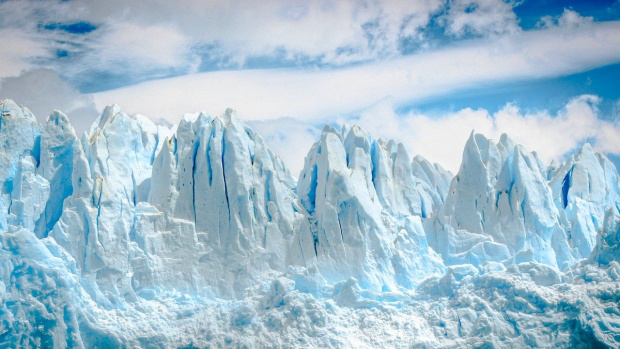

In [33]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://te-st.ru/wp-content/uploads/2020/04/glacier_title-620x349.jpg')
img = Image.open(BytesIO(response.content))
img

In [34]:
predict_class = pre_image(img,model)
print(predict_class)

glacier
